<a href="https://colab.research.google.com/github/nicolesorense/Ventilation-Prediction/blob/main/ventilation_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ventilation Prediction: Multimodal Deep Learning

This notebook implements a multimodal deep learning model to predict the need for mechanical ventilation in ICU patients using the MIMIC-IV dataset. It combines:
- Time-series data (vital signs, lab results) processed with an LSTM.
- Clinical notes processed with ClinicalBERT.
- Fusion layers to integrate both modalities for binary classification (ventilation: 0/1).

## Prerequisites
- **Python**: 3.8+
- **Dependencies**: Install via:
```bash
pip install torch transformers pandas numpy scikit-learn imblearn matplotlib tqdm
```
- **Data**: Preprocessed MIMIC-IV data from `ventilation_dl_preprocessing.ipynb` (see [PhysioNet](https://physionet.org/content/mimiciv/2.2/)).
- **Hardware**: GPU recommended (e.g., NVIDIA T4).

## Data Requirements
The notebook expects preprocessed data in `data/wrangled/`:
- **Time-series data**: `.npy` files (`train_combined_time_series_data.npy`, `val_combined_time_series_data.npy`, `test_combined_time_series_data.npy`) with shape `(samples, timesteps, features)`.
- **Ventilation labels**: `.npy` files (`train_vent_labels.npy`, `val_vent_labels.npy`, `test_vent_labels.npy`) with binary labels (0/1).
- **Clinical notes**: `.csv` files (`train_vent_notes.csv`, `val_vent_notes.csv`, `test_vent_notes.csv`) with a `Notes` column.
**Warning**: These files contain MIMIC-IV-derived data, including sensitive clinical notes. Do not share publicly. Ensure compliance with the MIMIC-IV Data Use Agreement (DUA).

## Usage
1. Clone the repository: `git clone https://github.com/nicolesorense/Ventilation-Prediction`
2. Install dependencies: `pip install -r requirements.txt`
3. Place preprocessed data in `data/wrangled/` (see `ventilation_dl_preprocessing.ipynb`).
4. Run the notebook cells sequentially.


In [ ]:
import os
import torch
import collections
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    precision_score
)
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset

## Data Loading
Loads preprocessed time-series data, ventilation labels, and clinical notes from `data/wrangled/`
**Warning**: These files contain MIMIC-IV-derived data, including sensitive clinical notes. Do not share publicly. Ensure compliance with the MIMIC-IV DUA.

In [ ]:
# Define data directory
data_dir = 'data/wrangled/'

# Load time-series data
print('Warning: The input .npy files contain MIMIC-IV-derived data. Do not share publicly.')
try:
    train_ts = np.load(os.path.join(data_dir, 'train_combined_time_series_data.npy'), allow_pickle=True)
    val_ts = np.load(os.path.join(data_dir, 'val_combined_time_series_data.npy'), allow_pickle=True)
    test_ts = np.load(os.path.join(data_dir, 'test_combined_time_series_data.npy'), allow_pickle=True)
except FileNotFoundError as e:
    print(f'Error: .npy file not found in {data_dir}: {e}')
    raise
# Load ventilation labels
try:
    train_vent_labels = np.load(os.path.join(data_dir, 'train_vent_labels.npy'), allow_pickle=True)
    val_vent_labels = np.load(os.path.join(data_dir, 'val_vent_labels.npy'), allow_pickle=True)
    test_vent_labels = np.load(os.path.join(data_dir, 'test_vent_labels.npy'), allow_pickle=True)
except FileNotFoundError as e:
    print(f'Error: .npy file not found in {data_dir}: {e}')
    raise

# Load clinical notes
try:
    train_notes_data = pd.read_csv(os.path.join(data_dir, 'train_vent_notes.csv'))
    val_notes_data = pd.read_csv(os.path.join(data_dir, 'val_vent_notes.csv'))
    test_notes_data = pd.read_csv(os.path.join(data_dir, 'test_vent_notes.csv'))
except FileNotFoundError as e:
    print(f'Error: CSV file not found in {data_dir}: {e}')
    raise

# Handle missing notes
train_notes_data['Notes'] = train_notes_data['Notes'].fillna('')
val_notes_data['Notes'] = val_notes_data['Notes'].fillna('')
test_notes_data['Notes'] = test_notes_data['Notes'].fillna('')

In [ ]:
# Set seed for determinism
def set_seed(seed):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [ ]:
# Change ts data to tensor
train_ts_tensor = torch.tensor(train_ts, dtype=torch.float32)
val_ts_tensor = torch.tensor(val_ts, dtype=torch.float32)
test_ts_tensor = torch.tensor(test_ts, dtype=torch.float32)

In [ ]:
# Function to load clinicalBERT
def load_clinicalbert():
  model_name = "emilyalsentzer/Bio_ClinicalBERT"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModel.from_pretrained(model_name)
  return tokenizer, model

In [ ]:
# Function to tokenize clinical notes
def tokenize_clinical_notes(clinical_notes, tokenizer, max_length=128):
  tokenized = tokenizer(
      clinical_notes,
      max_length=max_length,
      padding='max_length',
      truncation=True,
      return_tensors="pt"
  )
  return tokenized

In [ ]:
# Load clinicalBERT and its tokenizer
tokenizer, clinicalbert = load_clinicalbert()

In [ ]:
# Tokenize clinical notes
train_tokenized_inputs = tokenize_clinical_notes(train_notes_data['Notes'].tolist(), tokenizer)
val_tokenized_inputs = tokenize_clinical_notes(val_notes_data['Notes'].tolist(), tokenizer)
test_tokenized_inputs = tokenize_clinical_notes(test_notes_data['Notes'].tolist(), tokenizer)

In [ ]:
class MultiModalDataset(Dataset):
  def __init__(self, time_series_data, tokenized_data, labels):
    self.time_series_data = time_series_data
    self.input_ids = tokenized_data['input_ids'] # ids of the tokens
    self.attention_mask = tokenized_data['attention_mask']
    self.labels = labels

  def __len__(self):
    return len(self.time_series_data)

  def __getitem__(self, idx):
    return {
        'time_series': self.time_series_data[idx],
        'input_ids': self.input_ids[idx],
        'attention_mask': self.attention_mask[idx],
        'labels': self.labels[idx]
    }

# Create a dataset and dataloader
g = torch.Generator()
seed = 42
g.manual_seed(seed)
train_dataset = MultiModalDataset(train_ts, train_tokenized_inputs, train_vent_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
val_dataset = MultiModalDataset(val_ts, val_tokenized_inputs, val_vent_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, generator=g)
test_dataset = MultiModalDataset(test_ts, val_tokenized_inputs, test_vent_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, generator=g)

In [ ]:
class MultimodalModel(nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, lstm_num_layers, clinicalbert_model):
        super(MultimodalModel, self).__init__()

        # Masking value for time series
        self.mask_value = -1.0

        # LSTM for time series data
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True
        )
        self.lstm_norm = nn.LayerNorm(lstm_hidden_size)
        self.dropout_lstm = nn.Dropout(0.3)

        # ClinicalBERT for text data
        self.clinicalbert = clinicalbert_model
        self.bert_norm = nn.LayerNorm(768)  # ClinicalBERT's hidden size

        # Fusion layers
        self.dropout_fusion = nn.Dropout(0.3)
        self.fc_fusion = nn.Linear(lstm_hidden_size + 768, 128)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.fc_output = nn.Linear(128, 1)

        # Initialize weights to improve gradient flow
        self._init_weights()

    def _init_weights(self):
        """Initialize weights to prevent vanishing gradients."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

    def forward(self, time_series_data, input_ids, attention_mask):
        # Masking for LSTM input
        mask = (time_series_data != self.mask_value).float()
        time_series_data = time_series_data * mask

        # LSTM branch
        lstm_out, _ = self.lstm(time_series_data)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state
        lstm_out = self.lstm_norm(lstm_out)
        lstm_out = self.dropout_lstm(lstm_out)

        # ClinicalBERT branch
        bert_out = self.clinicalbert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled = bert_out.last_hidden_state[:, 0, :]  # CLS token embedding
        bert_pooled = self.bert_norm(bert_pooled)
        # Weight BERT output by non-empty notes to handle 72.6% empty notes
        non_empty = (attention_mask.sum(dim=1) > 1).float().unsqueeze(1)
        bert_pooled = bert_pooled * non_empty

        # Fusion
        combined = torch.cat((lstm_out, bert_pooled), dim=1)
        combined = self.dropout_fusion(combined)
        fused = self.fc_fusion(combined)
        fused = self.leaky_relu(fused)
        output = self.fc_output(fused)

        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Hyperparameters
lstm_input_size = train_ts_tensor.size(2)
lstm_hidden_size = 128
lstm_num_layers = 2
epochs = 30

# Initialize model
set_seed(42)
model = MultimodalModel(lstm_input_size, lstm_hidden_size, lstm_num_layers, clinicalbert)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5], device=device))
optimizer = torch.optim.Adam([
    {'params': model.clinicalbert.parameters(), 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() if 'clinicalbert' not in n], 'lr': 1e-4}
])

# Move model to device
model.to(device)

MultimodalModel(
  (lstm): LSTM(54, 128, num_layers=2, batch_first=True)
  (lstm_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout_lstm): Dropout(p=0.3, inplace=False)
  (clinicalbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            

In [ ]:
epochs = 30
patience = 5  # Number of epochs to wait for improvement
best_val_f1 = 0  # Track best F1-score for early stopping
patience_counter = 0  # Counter for early stopping
counter = 0  # Batch counter for gradient norm printing
best_model_path = "best_model.pth"  # Path to save best model

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0

    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        # Check for NaN or Inf values
        if torch.isnan(batch['time_series']).any() or torch.isinf(batch['time_series']).any():
            print(f"Batch {batch_idx}, Warning: NaN or Inf in time_series. Skipping.")
            continue

        # Skip batches with all empty notes
        attention_mask_batch = batch['attention_mask'].to(device, dtype=torch.long)
        non_empty_count = (attention_mask_batch.sum(dim=1) > 1).sum().item()
        if non_empty_count == 0:
            print(f"Batch {batch_idx}, All empty notes, skipping.")
            continue

        # Move data to device
        time_series_batch = batch['time_series'].to(device, dtype=torch.float32)
        input_ids_batch = batch['input_ids'].to(device, dtype=torch.long)
        labels_batch = batch['labels'].to(device, dtype=torch.float32)

        # Forward pass
        outputs = model(time_series_batch, input_ids_batch, attention_mask_batch).squeeze()

        # Ensure numerical stability
        labels_batch = labels_batch.type(torch.float32)
        loss = criterion(outputs, labels_batch)

        # Backward pass with gradient clipping
        optimizer.zero_grad()
        loss.backward()
        if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
            print(f"Batch {batch_idx}, NaN gradients detected")
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"Batch {batch_idx}, NaN in {name}")
        # Compute norm before clipping
        if counter % 50 == 0:
            grad_norm = torch.sqrt(sum(p.grad.norm(2)**2 for p in model.parameters() if p.grad is not None))
            print(f"Batch {batch_idx}, Gradient norm before clipping: {grad_norm.item()}")
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Relaxed clipping
        # Compute norm after clipping
        if counter % 50 == 0:
            grad_norm = torch.sqrt(sum(p.grad.norm(2)**2 for p in model.parameters() if p.grad is not None))
            print(f"Batch {batch_idx}, Gradient norm after clipping: {grad_norm.item()}")
        counter += 1
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            # Check for NaN or Inf values
            if torch.isnan(batch['time_series']).any() or torch.isinf(batch['time_series']).any():
                continue

            # Move data to device
            time_series_batch = batch['time_series'].to(device, dtype=torch.float32)
            input_ids_batch = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask_batch = batch['attention_mask'].to(device, dtype=torch.long)
            labels_batch = batch['labels'].to(device, dtype=torch.float32)

            # Forward pass
            outputs = model(time_series_batch, input_ids_batch, attention_mask_batch).squeeze()
            loss = criterion(outputs, labels_batch)

            # Convert logits to probabilities
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Collect for metrics
            all_labels.extend(labels_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    pr_auc = average_precision_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, "
          f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

    # Early stopping
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with F1: {best_val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement in F1. Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch 1/30:   0%|          | 1/302 [00:00<03:49,  1.31it/s]

Batch 0, Gradient norm before clipping: 119.1728515625
Batch 0, Gradient norm after clipping: 4.999999046325684


Epoch 1/30:  17%|█▋        | 51/302 [00:35<02:50,  1.47it/s]

Batch 50, Gradient norm before clipping: 13.427734375
Batch 50, Gradient norm after clipping: 5.0


Epoch 1/30:  33%|███▎      | 101/302 [01:07<02:10,  1.54it/s]

Batch 100, Gradient norm before clipping: 33.3239631652832
Batch 100, Gradient norm after clipping: 5.0


Epoch 1/30:  50%|█████     | 151/302 [01:40<01:41,  1.48it/s]

Batch 150, Gradient norm before clipping: 7.621754169464111
Batch 150, Gradient norm after clipping: 5.0


Epoch 1/30:  67%|██████▋   | 201/302 [02:13<01:06,  1.53it/s]

Batch 200, Gradient norm before clipping: 10.454065322875977
Batch 200, Gradient norm after clipping: 4.999999046325684


Epoch 1/30:  83%|████████▎ | 251/302 [02:45<00:33,  1.51it/s]

Batch 250, Gradient norm before clipping: 8.326299667358398
Batch 250, Gradient norm after clipping: 4.999999523162842


Epoch 1/30: 100%|█████████▉| 301/302 [03:18<00:00,  1.52it/s]

Batch 300, Gradient norm before clipping: 9.070840835571289
Batch 300, Gradient norm after clipping: 4.999999523162842


Epoch 1/30: 100%|██████████| 302/302 [03:18<00:00,  1.52it/s]


Epoch 1/30, Train Loss: 1.2014


Validation: 100%|██████████| 1710/1710 [05:46<00:00,  4.93it/s]


Epoch 1/30, Validation Loss: 0.6522, Precision: 0.0101, Recall: 0.7317, F1: 0.0199, ROC AUC: 0.8105, PR AUC: 0.0420
Saved best model with F1: 0.0199


Epoch 2/30:  16%|█▌        | 49/302 [00:31<02:46,  1.52it/s]

Batch 48, Gradient norm before clipping: 8.01874828338623
Batch 48, Gradient norm after clipping: 4.999999523162842


Epoch 2/30:  33%|███▎      | 99/302 [01:04<02:13,  1.52it/s]

Batch 98, Gradient norm before clipping: 6.5004496574401855
Batch 98, Gradient norm after clipping: 4.999999523162842


Epoch 2/30:  49%|████▉     | 149/302 [01:37<01:40,  1.52it/s]

Batch 148, Gradient norm before clipping: 5.929627418518066
Batch 148, Gradient norm after clipping: 5.000000476837158


Epoch 2/30:  66%|██████▌   | 199/302 [02:09<01:07,  1.52it/s]

Batch 198, Gradient norm before clipping: 7.482294082641602
Batch 198, Gradient norm after clipping: 4.999999523162842


Epoch 2/30:  82%|████████▏ | 249/302 [02:42<00:35,  1.51it/s]

Batch 248, Gradient norm before clipping: 6.117724895477295
Batch 248, Gradient norm after clipping: 4.999999523162842


Epoch 2/30:  99%|█████████▉| 299/302 [03:15<00:01,  1.53it/s]

Batch 298, Gradient norm before clipping: 8.29117202758789
Batch 298, Gradient norm after clipping: 4.999999046325684


Epoch 2/30: 100%|██████████| 302/302 [03:16<00:00,  1.53it/s]


Epoch 2/30, Train Loss: 1.0699


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 2/30, Validation Loss: 0.8553, Precision: 0.0073, Recall: 0.8098, F1: 0.0145, ROC AUC: 0.8158, PR AUC: 0.0467
No improvement in F1. Patience counter: 1/5


Epoch 3/30:  16%|█▌        | 47/302 [00:30<02:47,  1.52it/s]

Batch 46, Gradient norm before clipping: 9.747380256652832
Batch 46, Gradient norm after clipping: 4.999999523162842


Epoch 3/30:  32%|███▏      | 97/302 [01:03<02:15,  1.51it/s]

Batch 96, Gradient norm before clipping: 5.972350120544434
Batch 96, Gradient norm after clipping: 4.999998092651367


Epoch 3/30:  49%|████▊     | 147/302 [01:36<01:43,  1.50it/s]

Batch 146, Gradient norm before clipping: 8.197237014770508
Batch 146, Gradient norm after clipping: 4.999999046325684


Epoch 3/30:  65%|██████▌   | 197/302 [02:08<01:09,  1.51it/s]

Batch 196, Gradient norm before clipping: 6.790885925292969
Batch 196, Gradient norm after clipping: 4.999999046325684


Epoch 3/30:  82%|████████▏ | 247/302 [02:41<00:35,  1.53it/s]

Batch 246, Gradient norm before clipping: 5.588918209075928
Batch 246, Gradient norm after clipping: 4.999999046325684


Epoch 3/30:  98%|█████████▊| 297/302 [03:13<00:03,  1.53it/s]

Batch 296, Gradient norm before clipping: 5.663202285766602
Batch 296, Gradient norm after clipping: 4.999999523162842


Epoch 3/30: 100%|██████████| 302/302 [03:16<00:00,  1.54it/s]


Epoch 3/30, Train Loss: 1.0464


Validation: 100%|██████████| 1710/1710 [05:46<00:00,  4.94it/s]


Epoch 3/30, Validation Loss: 0.9501, Precision: 0.0058, Recall: 0.8829, F1: 0.0115, ROC AUC: 0.8238, PR AUC: 0.0448
No improvement in F1. Patience counter: 2/5


Epoch 4/30:  15%|█▍        | 45/302 [00:29<02:49,  1.52it/s]

Batch 44, Gradient norm before clipping: 7.6163506507873535
Batch 44, Gradient norm after clipping: 4.999999046325684


Epoch 4/30:  31%|███▏      | 95/302 [01:01<02:15,  1.53it/s]

Batch 94, Gradient norm before clipping: 7.216391563415527
Batch 94, Gradient norm after clipping: 4.999998092651367


Epoch 4/30:  48%|████▊     | 145/302 [01:34<01:42,  1.53it/s]

Batch 144, Gradient norm before clipping: 7.156438827514648
Batch 144, Gradient norm after clipping: 5.0


Epoch 4/30:  65%|██████▍   | 195/302 [02:07<01:11,  1.51it/s]

Batch 194, Gradient norm before clipping: 6.8988118171691895
Batch 194, Gradient norm after clipping: 4.999999046325684


Epoch 4/30:  81%|████████  | 245/302 [02:39<00:37,  1.52it/s]

Batch 244, Gradient norm before clipping: 5.330608367919922
Batch 244, Gradient norm after clipping: 4.999999523162842


Epoch 4/30:  98%|█████████▊| 295/302 [03:12<00:04,  1.51it/s]

Batch 294, Gradient norm before clipping: 9.605249404907227
Batch 294, Gradient norm after clipping: 4.999999046325684


Epoch 4/30: 100%|██████████| 302/302 [03:16<00:00,  1.54it/s]


Epoch 4/30, Train Loss: 1.0311


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 4/30, Validation Loss: 0.6998, Precision: 0.0104, Recall: 0.7317, F1: 0.0205, ROC AUC: 0.8234, PR AUC: 0.0426
Saved best model with F1: 0.0205


Epoch 5/30:  14%|█▍        | 43/302 [00:28<02:51,  1.51it/s]

Batch 42, Gradient norm before clipping: 7.041126728057861
Batch 42, Gradient norm after clipping: 4.999998092651367


Epoch 5/30:  31%|███       | 93/302 [01:00<02:18,  1.51it/s]

Batch 92, Gradient norm before clipping: 5.892230033874512
Batch 92, Gradient norm after clipping: 4.999999523162842


Epoch 5/30:  47%|████▋     | 143/302 [01:33<01:44,  1.52it/s]

Batch 142, Gradient norm before clipping: 6.212740421295166
Batch 142, Gradient norm after clipping: 5.0


Epoch 5/30:  64%|██████▍   | 193/302 [02:06<01:11,  1.52it/s]

Batch 192, Gradient norm before clipping: 23.70815658569336
Batch 192, Gradient norm after clipping: 4.999999523162842


Epoch 5/30:  80%|████████  | 243/302 [02:38<00:38,  1.51it/s]

Batch 242, Gradient norm before clipping: 5.839363098144531
Batch 242, Gradient norm after clipping: 4.999999523162842


Epoch 5/30:  97%|█████████▋| 293/302 [03:11<00:05,  1.51it/s]

Batch 292, Gradient norm before clipping: 6.366395950317383
Batch 292, Gradient norm after clipping: 4.999999523162842


Epoch 5/30: 100%|██████████| 302/302 [03:16<00:00,  1.53it/s]


Epoch 5/30, Train Loss: 0.9984


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 5/30, Validation Loss: 0.6954, Precision: 0.0112, Recall: 0.7220, F1: 0.0220, ROC AUC: 0.8262, PR AUC: 0.0439
Saved best model with F1: 0.0220


Epoch 6/30:  14%|█▎        | 41/302 [00:26<02:51,  1.52it/s]

Batch 40, Gradient norm before clipping: 3.9132046699523926
Batch 40, Gradient norm after clipping: 3.9132046699523926


Epoch 6/30:  30%|███       | 91/302 [00:59<02:18,  1.52it/s]

Batch 90, Gradient norm before clipping: 15.961169242858887
Batch 90, Gradient norm after clipping: 4.999999523162842


Epoch 6/30:  47%|████▋     | 141/302 [01:32<01:45,  1.52it/s]

Batch 140, Gradient norm before clipping: 4.2560224533081055
Batch 140, Gradient norm after clipping: 4.2560224533081055


Epoch 6/30:  63%|██████▎   | 191/302 [02:04<01:12,  1.52it/s]

Batch 190, Gradient norm before clipping: 6.296736717224121
Batch 190, Gradient norm after clipping: 4.999998092651367


Epoch 6/30:  80%|███████▉  | 241/302 [02:37<00:40,  1.52it/s]

Batch 240, Gradient norm before clipping: 4.833546161651611
Batch 240, Gradient norm after clipping: 4.833546161651611


Epoch 6/30:  96%|█████████▋| 291/302 [03:09<00:07,  1.51it/s]

Batch 290, Gradient norm before clipping: 14.558073997497559
Batch 290, Gradient norm after clipping: 5.000000476837158


Epoch 6/30: 100%|██████████| 302/302 [03:16<00:00,  1.54it/s]


Epoch 6/30, Train Loss: 0.9933


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 6/30, Validation Loss: 0.7015, Precision: 0.0114, Recall: 0.7220, F1: 0.0224, ROC AUC: 0.8238, PR AUC: 0.0414
Saved best model with F1: 0.0224


Epoch 7/30:  13%|█▎        | 39/302 [00:25<02:53,  1.51it/s]

Batch 38, Gradient norm before clipping: 8.224251747131348
Batch 38, Gradient norm after clipping: 4.999999046325684


Epoch 7/30:  29%|██▉       | 89/302 [00:58<02:19,  1.52it/s]

Batch 88, Gradient norm before clipping: 6.50203275680542
Batch 88, Gradient norm after clipping: 4.999999523162842


Epoch 7/30:  46%|████▌     | 139/302 [01:30<01:48,  1.51it/s]

Batch 138, Gradient norm before clipping: 7.654526710510254
Batch 138, Gradient norm after clipping: 4.999999046325684


Epoch 7/30:  63%|██████▎   | 189/302 [02:03<01:14,  1.51it/s]

Batch 188, Gradient norm before clipping: 11.211405754089355
Batch 188, Gradient norm after clipping: 4.999999523162842


Epoch 7/30:  79%|███████▉  | 239/302 [02:36<00:41,  1.52it/s]

Batch 238, Gradient norm before clipping: 7.5423126220703125
Batch 238, Gradient norm after clipping: 4.999998092651367


Epoch 7/30:  96%|█████████▌| 289/302 [03:08<00:08,  1.52it/s]

Batch 288, Gradient norm before clipping: 5.48708963394165
Batch 288, Gradient norm after clipping: 4.999998092651367


Epoch 7/30: 100%|██████████| 302/302 [03:16<00:00,  1.53it/s]


Epoch 7/30, Train Loss: 0.9856


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 7/30, Validation Loss: 0.4734, Precision: 0.0170, Recall: 0.6878, F1: 0.0332, ROC AUC: 0.8260, PR AUC: 0.0408
Saved best model with F1: 0.0332


Epoch 8/30:  12%|█▏        | 37/302 [00:24<02:55,  1.51it/s]

Batch 36, Gradient norm before clipping: 11.300021171569824
Batch 36, Gradient norm after clipping: 5.000000476837158


Epoch 8/30:  29%|██▉       | 87/302 [00:56<02:21,  1.52it/s]

Batch 86, Gradient norm before clipping: 3.6024601459503174
Batch 86, Gradient norm after clipping: 3.6024601459503174


Epoch 8/30:  45%|████▌     | 137/302 [01:29<01:48,  1.52it/s]

Batch 136, Gradient norm before clipping: 6.216986179351807
Batch 136, Gradient norm after clipping: 5.0


Epoch 8/30:  62%|██████▏   | 187/302 [02:02<01:15,  1.52it/s]

Batch 186, Gradient norm before clipping: 4.817618370056152
Batch 186, Gradient norm after clipping: 4.817618370056152


Epoch 8/30:  78%|███████▊  | 237/302 [02:34<00:42,  1.52it/s]

Batch 236, Gradient norm before clipping: 8.183176040649414
Batch 236, Gradient norm after clipping: 4.999997138977051


Epoch 8/30:  95%|█████████▌| 287/302 [03:07<00:09,  1.52it/s]

Batch 286, Gradient norm before clipping: 12.0787353515625
Batch 286, Gradient norm after clipping: 5.0


Epoch 8/30: 100%|██████████| 302/302 [03:16<00:00,  1.53it/s]


Epoch 8/30, Train Loss: 0.9751


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 8/30, Validation Loss: 0.6760, Precision: 0.0116, Recall: 0.7171, F1: 0.0228, ROC AUC: 0.8238, PR AUC: 0.0385
No improvement in F1. Patience counter: 1/5


Epoch 9/30:  12%|█▏        | 35/302 [00:22<02:54,  1.53it/s]

Batch 34, Gradient norm before clipping: 10.651782989501953
Batch 34, Gradient norm after clipping: 5.0


Epoch 9/30:  28%|██▊       | 85/302 [00:55<02:22,  1.52it/s]

Batch 84, Gradient norm before clipping: 6.605788230895996
Batch 84, Gradient norm after clipping: 4.999998092651367


Epoch 9/30:  45%|████▍     | 135/302 [01:28<01:51,  1.50it/s]

Batch 134, Gradient norm before clipping: 3.2912747859954834
Batch 134, Gradient norm after clipping: 3.2912747859954834


Epoch 9/30:  61%|██████▏   | 185/302 [02:00<01:16,  1.52it/s]

Batch 184, Gradient norm before clipping: 6.215870380401611
Batch 184, Gradient norm after clipping: 4.999998569488525


Epoch 9/30:  78%|███████▊  | 235/302 [02:33<00:44,  1.52it/s]

Batch 234, Gradient norm before clipping: 11.071065902709961
Batch 234, Gradient norm after clipping: 4.999999523162842


Epoch 9/30:  94%|█████████▍| 285/302 [03:06<00:11,  1.52it/s]

Batch 284, Gradient norm before clipping: 3.3978071212768555
Batch 284, Gradient norm after clipping: 3.3978071212768555


Epoch 9/30: 100%|██████████| 302/302 [03:16<00:00,  1.54it/s]


Epoch 9/30, Train Loss: 0.9696


Validation: 100%|██████████| 1710/1710 [05:45<00:00,  4.94it/s]


Epoch 9/30, Validation Loss: 0.7168, Precision: 0.0117, Recall: 0.7268, F1: 0.0230, ROC AUC: 0.8249, PR AUC: 0.0385
No improvement in F1. Patience counter: 2/5


Epoch 10/30:  11%|█         | 33/302 [00:21<02:57,  1.52it/s]

Batch 32, Gradient norm before clipping: 5.122507572174072
Batch 32, Gradient norm after clipping: 4.999999523162842


Epoch 10/30:  27%|██▋       | 83/302 [00:54<02:24,  1.52it/s]

Batch 82, Gradient norm before clipping: 3.6107425689697266
Batch 82, Gradient norm after clipping: 3.6107425689697266


Epoch 10/30:  35%|███▍      | 105/302 [01:09<02:09,  1.52it/s]


KeyboardInterrupt: 

In [ ]:
# Set model to best model
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

Evaluating: 100%|██████████| 1710/1710 [05:50<00:00,  4.88it/s]


Probabilities: [0.15158531 0.17707962 0.19664988 ... 0.18661487 0.3228403  0.7432783 ]

Default Metrics (Threshold=0.5):
Accuracy: 0.9852
F1-Score: 0.1197
PR AUC: 0.0400
ROC AUC: 0.8260

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92     54506
         1.0       0.02      0.69      0.03       205

    accuracy                           0.85     54711
   macro avg       0.51      0.77      0.48     54711
weighted avg       0.99      0.85      0.92     54711


Confusion Matrix:
[[53847   659]
 [  150    55]]

Threshold Tuning Results:
Threshold  F1-Score   Accuracy   Precision  Recall     Confusion Matrix    
0.10       0.0081     0.0894     0.0041     0.9951     [[4686,49820],[1,204]]
0.12       0.0084     0.1309     0.0042     0.9854     [[6957,47549],[3,202]]
0.14       0.0091     0.2001     0.0046     0.9805     [[10744,43762],[4,201]]
0.16       0.0102     0.3153     0.0051     0.9415     [[17057,37449],[12,1

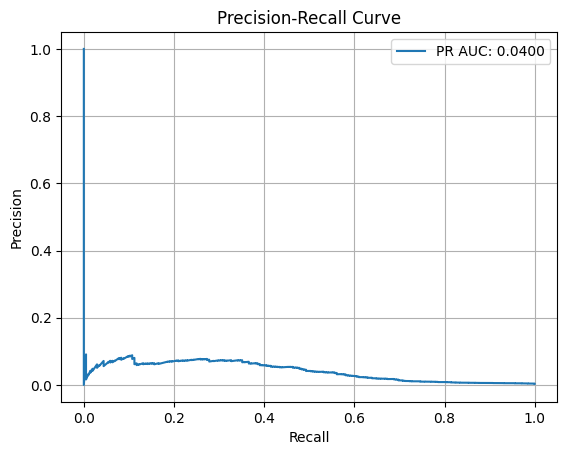

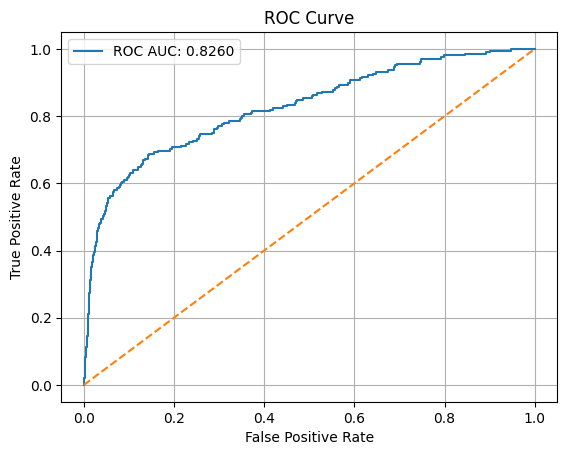

In [ ]:
def evaluate_model(model, dataloader, device, thresholds=np.arange(0.1, 1.0, 0.1), optimize_metric='f1'):
    """
    Evaluate the model on the validation set, tuning the prediction threshold.

    Args:
        model: The PyTorch model (MultimodalModel).
        dataloader: DataLoader for the validation set.
        device: Device to run the model on ('cuda' or 'cpu').
        thresholds: List of thresholds to evaluate (default: 0.1 to 0.9 in steps of 0.1).
        optimize_metric: Metric to optimize ('f1', 'precision', 'recall', 'accuracy').

    Returns:
        dict: Metrics for the default threshold (0.5).
        dict: Best threshold and corresponding metrics.
    """
    model.eval()
    all_labels = []
    all_probs = []

    # Collect predictions and labels
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            time_series_batch = batch['time_series'].to(device, dtype=torch.float32)
            input_ids_batch = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask_batch = batch['attention_mask'].to(device, dtype=torch.long)
            labels_batch = batch['labels'].to(device, dtype=torch.float32)

            # Forward pass
            outputs = model(time_series_batch, input_ids_batch, attention_mask_batch).squeeze()
            outputs = torch.sigmoid(outputs)

            # Store labels and probabilities
            all_labels.extend(labels_batch.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    # Convert to arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    print("Probabilities:", all_probs)

    # Initialize results
    threshold_results = []
    best_threshold = 0.5
    best_score = -1
    default_metrics = {}

    # Evaluate across thresholds
    for threshold in thresholds:
        # Generate predictions
        predictions = (all_probs > threshold).astype(int)
        cm = confusion_matrix(all_labels, predictions)
        TN, FP, FN, TP = cm.ravel()

        # Calculate metrics
        f1 = f1_score(all_labels, predictions)
        acc = accuracy_score(all_labels, predictions)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        cm = confusion_matrix(all_labels, predictions)

        # Store results
        result = {
            'threshold': threshold,
            'f1': f1,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
            }
        threshold_results.append(result)

        # Update best threshold
        score = result[optimize_metric]
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_metrics = result

        # Store default metrics for threshold=0.5
        if abs(threshold - 0.5) < 1e-6:
            default_metrics = result

    # Compute accuracy, f1, confusion_matrix
    default_metrics['accuracy'] = accuracy_score(all_labels, (all_probs > best_threshold).astype(int))
    default_metrics['f1'] = f1_score(all_labels, (all_probs > best_threshold).astype(int))
    default_metrics['confusion_matrix'] = confusion_matrix(all_labels, (all_probs > best_threshold).astype(int))

    # Compute PR and ROC curves
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Update default metrics with AUCs
    default_metrics['pr_auc'] = pr_auc
    default_metrics['roc_auc'] = roc_auc

    # Print default metrics (threshold=0.5)
    print("\nDefault Metrics (Threshold=0.5):")
    print(f"Accuracy: {default_metrics['accuracy']:.4f}")
    print(f"F1-Score: {default_metrics['f1']:.4f}")
    print(f"PR AUC: {default_metrics['pr_auc']:.4f}")
    print(f"ROC AUC: {default_metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, (all_probs > 0.5).astype(int)))
    print("\nConfusion Matrix:")
    print(default_metrics['confusion_matrix'])

    # Print threshold tuning results
    print("\nThreshold Tuning Results:")
    print(f"{'Threshold':<10} {'F1-Score':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'Confusion Matrix':<20}")
    for result in threshold_results:
        cm_str = f"[[{result['confusion_matrix'][0,0]},{result['confusion_matrix'][0,1]}],[{result['confusion_matrix'][1,0]},{result['confusion_matrix'][1,1]}]]"
        print(f"{result['threshold']:<10.2f} {result['f1']:<10.4f} {result['accuracy']:<10.4f} {result['precision']:<10.4f} {result['recall']:<10.4f} {cm_str:<20}")

    # Print best threshold
    print(f"\nBest Threshold (optimizing {optimize_metric}): {best_threshold:.2f}")
    print(f"Best Metrics: F1={best_metrics['f1']:.4f}, Accuracy={best_metrics['accuracy']:.4f}, Precision={best_metrics['precision']:.4f}, Recall={best_metrics['recall']:.4f}")
    print(f"Best Confusion Matrix:\n{best_metrics['confusion_matrix']}")

    # Plot PR Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC: {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return default_metrics, best_metrics

default_metrics, best_metrics = evaluate_model(model, val_dataloader, device, thresholds=np.arange(0.1, 1.0, 0.02), optimize_metric='f1')

In [ ]:
# Final evaluation
optimal_threshold = 0.96
default_metrics, best_metrics = evaluate_model(model, test_dataloader, device, thresholds=[optimal_threshold], optimize_metric='f1')

Evaluating: 100%|██████████| 1710/1710 [05:46<00:00,  4.93it/s]


Probabilities: [0.23193991 0.12114962 0.29710668 ... 0.3234747  0.7124042  0.06586133]

Default Metrics (Threshold=0.5):
Accuracy: 0.9853
F1-Score: 0.0928
PR AUC: 0.0297
ROC AUC: 0.8253

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90     54507
         1.0       0.01      0.71      0.03       204

    accuracy                           0.82     54711
   macro avg       0.51      0.77      0.47     54711
weighted avg       1.00      0.82      0.90     54711


Confusion Matrix:


KeyError: 'confusion_matrix'

In [ ]:
model.eval()
all_labels = []
all_probs = []

# Collect predictions and labels
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        time_series_batch = batch['time_series'].to(device, dtype=torch.float32)
        input_ids_batch = batch['input_ids'].to(device, dtype=torch.long)
        attention_mask_batch = batch['attention_mask'].to(device, dtype=torch.long)
        labels_batch = batch['labels'].to(device, dtype=torch.float32)

        # Forward pass
        outputs = model(time_series_batch, input_ids_batch, attention_mask_batch).squeeze()
        outputs = torch.sigmoid(outputs)

        # Store labels and probabilities
        all_labels.extend(labels_batch.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
y_pred_proba = np.array(all_probs)
print("Probabilities:", all_probs)


Evaluating: 100%|██████████| 1710/1710 [05:48<00:00,  4.91it/s]


Probabilities: [np.float32(0.17084518), np.float32(0.12486327), np.float32(0.19674203), np.float32(0.86981326), np.float32(0.3594995), np.float32(0.16988075), np.float32(0.21510099), np.float32(0.7193654), np.float32(0.22276556), np.float32(0.28174308), np.float32(0.5075134), np.float32(0.1838425), np.float32(0.09520812), np.float32(0.14172895), np.float32(0.2926607), np.float32(0.15563864), np.float32(0.81171006), np.float32(0.27407852), np.float32(0.16546309), np.float32(0.11038087), np.float32(0.16804263), np.float32(0.20183127), np.float32(0.6125611), np.float32(0.09806494), np.float32(0.09441042), np.float32(0.3010483), np.float32(0.19526365), np.float32(0.16242786), np.float32(0.21086289), np.float32(0.30189294), np.float32(0.25251418), np.float32(0.057969663), np.float32(0.1471586), np.float32(0.24110688), np.float32(0.16742879), np.float32(0.7900969), np.float32(0.30544564), np.float32(0.21095178), np.float32(0.14598832), np.float32(0.25361097), np.float32(0.61977917), np.float

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_vent_labels, y_pred_proba)
auc_score = roc_auc_score(test_vent_labels, y_pred_proba)
print(f"Deep Learning AUC: {auc_score:.4f}")

Deep Learning AUC: 0.4706
